In [1]:
import os.path as op

import matplotlib.pyplot as plt

from hnn_core import calcium_model, read_params, simulate_dipole, average_dipoles, read_dipole
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import pickle
import numpy as np
from hnn_core import MPIBackend

In [2]:
import hnn_core

hnn_core_root = op.join(op.dirname(hnn_core.__file__))

# The number of cores may need modifying depending on your current machine.
n_procs = 8

In [3]:
# load participant data 
df = pd.read_csv('HNN_data_TEP_dipole_0_300.txt', sep = ' ')
data = [line.split('\t') for line in df.iloc[:,0].tolist()]

# data = np.rot90(data, k=1) 
# data = pd.DataFrame(data, columns=["Time", "Dipole"])
data = pd.DataFrame(data)
print(data)
data.to_csv("HNN_data_TEP_dipole_0_300_formatted.txt", sep="\t", index=False, header=False)

partic_data = hnn_core.read_dipole("HNN_data_TEP_dipole_0_300_formatted.txt")

# partic_data = np.array([float(data[0]), float(data[1])])
# print(partic_data[0])


                  0              1
0      1.0000000000  -0.0002592449
1      2.0000000000  -0.0002592449
2      3.0000000000  -0.0002592449
3      4.0000000000  -0.0002592449
4      5.0000000000  -0.0002592449
..              ...            ...
295  296.0000000000  -0.0001894256
296  297.0000000000  -0.0001739065
297  298.0000000000  -0.0001515077
298  299.0000000000  -0.0001020627
299  300.0000000000  -0.0000269744

[300 rows x 2 columns]


In [4]:
# load params from TEP simulation
with open('param_files/net_TEP_calcium_params_v3.pkl', 'rb') as f:
    TEP_params = pickle.load(f)

In [5]:
TEP_params

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

In [6]:
def make_net_and_simulate(params, n_trials = 2, tstop=None):
    # make nets
    net = calcium_model(params=params, add_drives_from_params=True)

    # simulate dipoles
    if tstop is not None:
        with MPIBackend(n_procs=n_trials, mpi_cmd='mpiexec'):
            dpl = simulate_dipole(net, tstop=tstop, n_trials=n_trials)
    else: 
        with MPIBackend(n_procs=n_trials, mpi_cmd='mpiexec'):
            dpl = simulate_dipole(net, tstop=params["tstop"], n_trials=n_trials)
    return dpl, net

In [7]:
def scale_and_smooth(dpls, window_len=10, scaling_factor=1):
    dpls_smoothed = deepcopy(dpls)
    for dpl in dpls_smoothed:
        dpl.smooth(window_len).scale(scaling_factor)
    return dpls_smoothed

In [8]:
# simulate TEP
init_dpl, init_net = make_net_and_simulate(TEP_params)

MPI will run 2 trial(s) sequentially by distributing network neurons over 2 processes.
numprocs=2
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
T

In [9]:
init_dpl_smoothed = scale_and_smooth(init_dpl,scaling_factor=1)

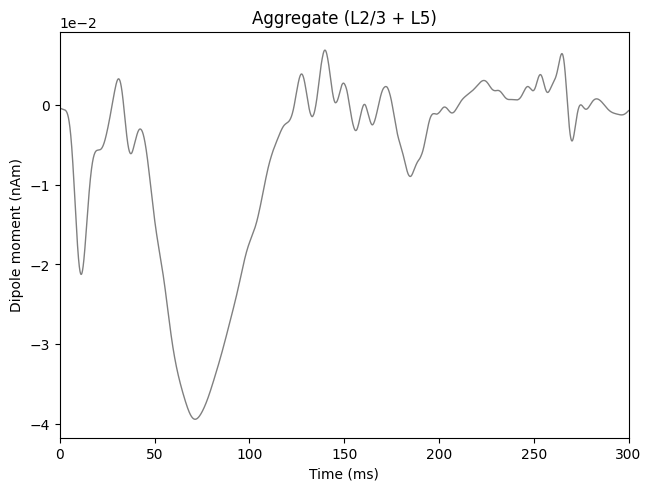

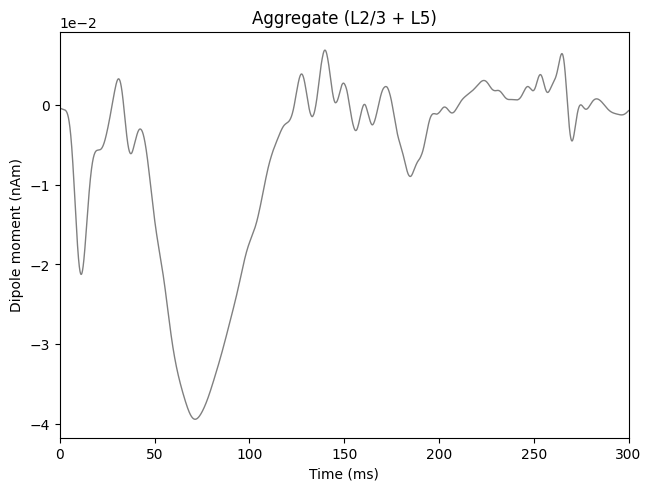

In [186]:
init_dpl_smoothed[1].plot()

In [115]:
partic_data = scale_and_smooth([partic_data], scaling_factor=3.33)

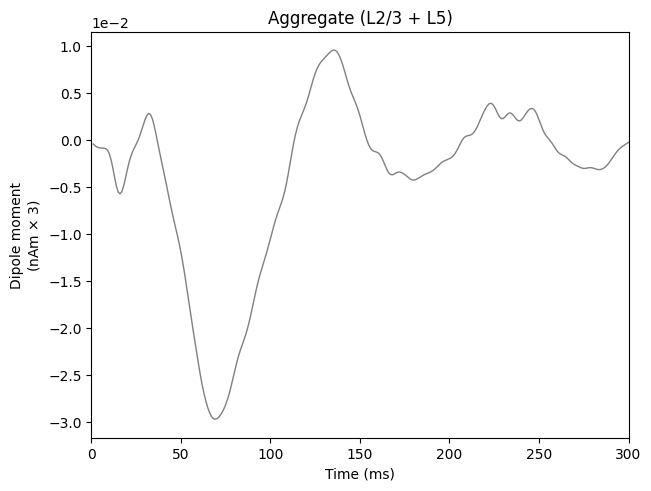

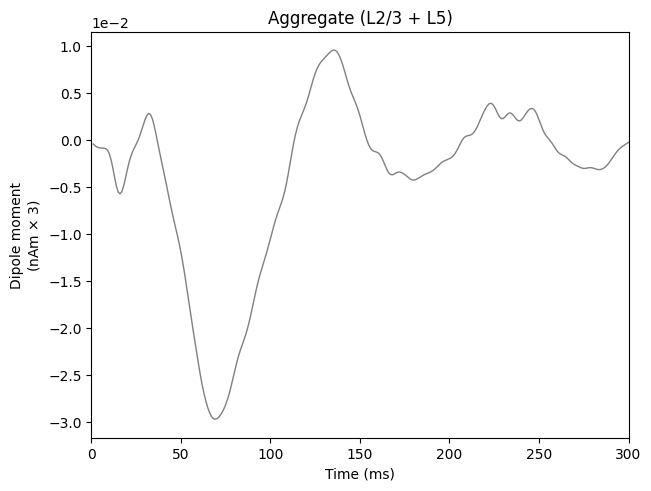

In [116]:
partic_data[0].plot()

In [168]:
# format the weights to match the optimizer
target_mapping = {
    'L2Basket': 'L2_basket',
    'L2Pyr': 'L2_pyramidal',
    'L5Basket': 'L5_basket',
    'L5Pyr': 'L5_pyramidal'
}

In [250]:
# get weight matrices from params file 

drives = ['evprox_1','evprox_2','evprox_3','evdist_1','evdist_2','evdist_3']

drive_ampa_weights = ['ampa_' + drive for drive in drives]
drive_nmda_weights = ['nmda_' + drive for drive in drives]

def get_weight(params):
    
    all_weights = {}

    # List of target keys
    targets = ['L2Basket', 'L2Pyr', 'L5Basket', 'L5Pyr']

    for i in range(len(drives)):
        weights_ampa = {}
        weights_nmda = {}

        # Iterate over targets and check key existence before assignment
        for target in targets:
            ampa_key = f'gbar_{drives[i]}_{target}_ampa'
            nmda_key = f'gbar_{drives[i]}_{target}_nmda'

            if ampa_key in params:
                weights_ampa[target_mapping[target]] = params[ampa_key]  

            if nmda_key in params:
                weights_nmda[target_mapping[target]] = params[nmda_key]
        
        all_weights.update({drive_ampa_weights[i]: weights_ampa, 
                           drive_nmda_weights[i]: weights_nmda})
    
    
    return all_weights

In [251]:
weight = get_weight(TEP_params)
print(weight)

{'ampa_evprox_1': {'L2_basket': 3.1877600000000004, 'L2_pyramidal': 0.17786000000000002, 'L5_basket': 6.059539999999999, 'L5_pyramidal': 0.0073}, 'nmda_evprox_1': {'L2_basket': 0.0, 'L2_pyramidal': 0.0, 'L5_basket': 0.0, 'L5_pyramidal': 0.0}, 'ampa_evprox_2': {'L2_basket': 0.063, 'L2_pyramidal': 0.006299999999999999, 'L5_basket': 0.018326, 'L5_pyramidal': 0.00035}, 'nmda_evprox_2': {'L2_basket': 0.0, 'L2_pyramidal': 0.0, 'L5_basket': 0.175, 'L5_pyramidal': 0.0}, 'ampa_evprox_3': {'L2_basket': 4.5, 'L2_pyramidal': 0.6465000000000001, 'L5_basket': 0.748, 'L5_pyramidal': 0.043750000000000004}, 'nmda_evprox_3': {'L2_basket': 12.5, 'L2_pyramidal': 0.0, 'L5_basket': 12.5, 'L5_pyramidal': 0.0}, 'ampa_evdist_1': {'L2_basket': 0.041872349999999996, 'L2_pyramidal': 0.0009476999999999999, 'L5_pyramidal': 0.06110325}, 'nmda_evdist_1': {'L2_basket': 0.01014285, 'L2_pyramidal': 0.0045399, 'L5_pyramidal': 0.1577562}, 'ampa_evdist_2': {'L2_basket': 0.0024741719999999997, 'L2_pyramidal': 0.003146003999

In [12]:
TEP_params

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

In [243]:
synaptic_delays_p = {'L2_basket': TEP_params['input_prox_A_delay_L2'], 'L2_pyramidal': TEP_params['input_prox_A_delay_L2'],
                     'L5_basket': TEP_params['input_prox_A_delay_L5'], 'L5_pyramidal': TEP_params['input_prox_A_delay_L5']}
synaptic_delays_d = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                    'L5_pyramidal': 0.1}

In [244]:
synaptic_delays_p

{'L2_basket': 0.1, 'L2_pyramidal': 0.1, 'L5_basket': 1.0, 'L5_pyramidal': 1.0}

In [246]:
dist2_weight_ampa = {key: value * 1 for key, value in deepcopy(weight['ampa_evdist_2']).items()}
dist2_weight_nmda = {key: value * 1 for key, value in deepcopy(weight['nmda_evdist_2']).items()}

# "gbar_evdist_2_L2Basket_ampa": 0.0024741719999999997,
#     "gbar_evdist_2_L2Basket_nmda": 0.039215124,
#     "gbar_evdist_2_L2Pyr_ampa": 0.0031460039999999996,
#     "gbar_evdist_2_L2Pyr_nmda": 0.004143708,
#     "gbar_evdist_2_L5Pyr_ampa": 0.030831731999999997,
#     "gbar_evdist_2_L5Pyr_nmda": 0.006008543999999999,

In [232]:
print(dist2_weight_ampa)
print(weight['ampa_evdist_2'])
print(dist2_weight_nmda)

{'L2_basket': 0.0037112579999999994, 'L2_pyramidal': 0.0047190059999999995, 'L5_pyramidal': 0.046247597999999994}
{'L2_basket': 0.0024741719999999997, 'L2_pyramidal': 0.0031460039999999996, 'L5_pyramidal': 0.030831731999999997}
{'L2_basket': 0.058822686, 'L2_pyramidal': 0.006215562000000001, 'L5_pyramidal': 0.009012816}


In [240]:
init_net.connectivity

[evdist1 -> L2_basket
 cell counts: 35 srcs, 35 targets
 connection probability: 1.0 
 loc: 'distal'; receptor: 'ampa'
 weight: 0.041872349999999996; delay: 0.1; lamtha: 3.0
  ,
 evdist1 -> L2_basket
 cell counts: 35 srcs, 35 targets
 connection probability: 1.0 
 loc: 'distal'; receptor: 'nmda'
 weight: 0.01014285; delay: 0.1; lamtha: 3.0
  ,
 evdist1 -> L2_pyramidal
 cell counts: 100 srcs, 100 targets
 connection probability: 1.0 
 loc: 'distal'; receptor: 'ampa'
 weight: 0.0009476999999999999; delay: 0.1; lamtha: 3.0
  ,
 evdist1 -> L2_pyramidal
 cell counts: 100 srcs, 100 targets
 connection probability: 1.0 
 loc: 'distal'; receptor: 'nmda'
 weight: 0.0045399; delay: 0.1; lamtha: 3.0
  ,
 evdist1 -> L5_pyramidal
 cell counts: 100 srcs, 100 targets
 connection probability: 1.0 
 loc: 'distal'; receptor: 'ampa'
 weight: 0.06110325; delay: 0.1; lamtha: 3.0
  ,
 evdist1 -> L5_pyramidal
 cell counts: 100 srcs, 100 targets
 connection probability: 1.0 
 loc: 'distal'; receptor: 'nmda'
 

In [247]:
test_net = calcium_model()
test_net.add_evoked_drive('evdist2',
                         mu=TEP_params['t_evdist_2'],
                         sigma=TEP_params["sigma_t_evdist_2"],
                         numspikes=1,
                         location='distal',
                         weights_ampa=dist2_weight_ampa,
                         weights_nmda=dist2_weight_nmda,
                         synaptic_delays=synaptic_delays_d)

In [248]:
with MPIBackend(n_procs=1, mpi_cmd='mpiexec'):
    test_dpl = simulate_dipole(test_net, tstop=300, n_trials=1)
smoothed_test_dpl = scale_and_smooth(test_dpl)

MPIBackend is set to use 1 core: transferring the simulation to JoblibBackend....
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...


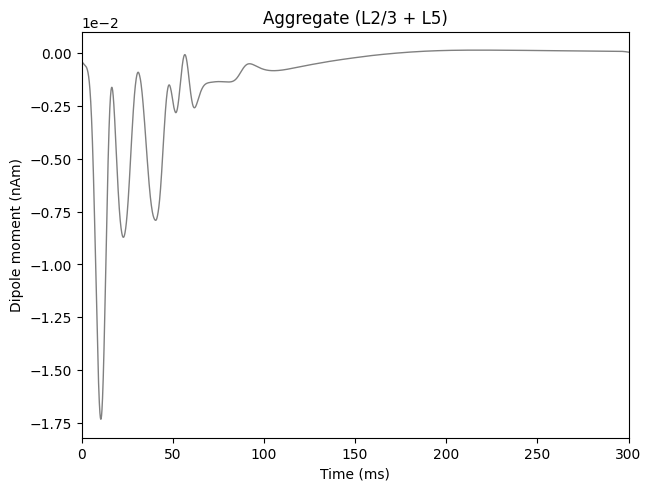

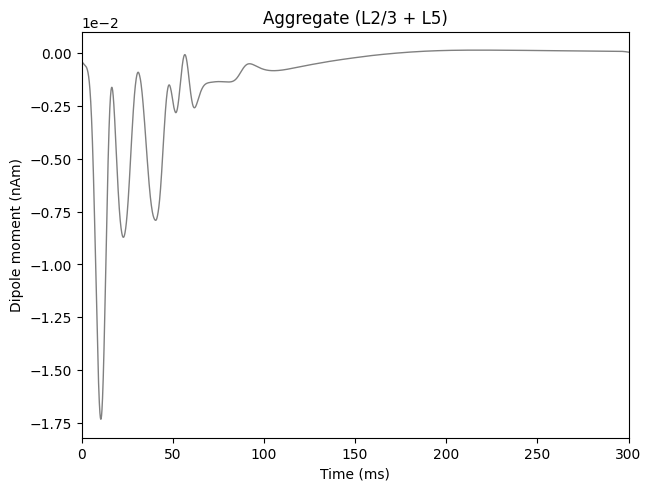

In [249]:
smoothed_test_dpl[0].plot()

In [252]:
# set_params function takes in a net without drives and dict of the params we wish to optimize

def set_params(net, params):

    # Prox 1
    weights_ampa_p1 = {'L2_basket':
                       params['gbar_evprox_1_L2Basket_ampa'],
                       'L2_pyramidal':
                       params['gbar_evprox_1_L2Pyr_ampa'],
                       'L5_pyramidal':
                       params['gbar_evprox_1_L5Pyr_ampa'],
                       'L5_basket':
                       params['gbar_evprox_1_L5Basket_ampa'],}
    weights_nmda_p1 = {'L2_basket':
                       params['gbar_evprox_1_L2Basket_nmda'],
                       'L2_pyramidal':
                       params['gbar_evprox_1_L2Pyr_nmda'],
                       'L5_pyramidal':
                       params['gbar_evprox_1_L5Pyr_nmda'],
                       'L5_basket':
                       params['gbar_evprox_1_L5Basket_nmda']}
    net.add_evoked_drive('evprox1',
                         mu=params["t_evprox_1"],
                         sigma=params["sigma_t_evprox_1"],
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p1,
                         weights_nmda=weights_nmda_p1,
                         synaptic_delays=synaptic_delays_p)
    
    # Prox 2
    net.add_evoked_drive('evprox2',
                         mu=TEP_params['t_evprox_2'],
                         sigma=TEP_params["sigma_t_evprox_2"],
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weight['ampa_evprox_2'],
                         weights_nmda=weight['nmda_evprox_2'],
                         synaptic_delays=synaptic_delays_p)
    
    # Prox 3
    weights_ampa_p3 = {'L2_basket':
                       params['gbar_evprox_3_L2Basket_ampa'],
                       'L2_pyramidal':
                       params['gbar_evprox_3_L2Pyr_ampa'],
                       'L5_pyramidal':
                       params['gbar_evprox_3_L5Pyr_ampa'],
                       'L5_basket':
                       params['gbar_evprox_3_L5Basket_ampa'],}
    weights_nmda_p3 = {'L2_basket':
                       params['gbar_evprox_3_L2Basket_nmda'],
                       'L2_pyramidal':
                       params['gbar_evprox_3_L2Pyr_nmda'],
                       'L5_pyramidal':
                       params['gbar_evprox_3_L5Pyr_nmda'],
                       'L5_basket':
                       params['gbar_evprox_3_L5Basket_nmda']}
    net.add_evoked_drive('evprox3',
                         mu=params['t_evprox_3'],
                         sigma=params["sigma_t_evprox_3"],
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p3,
                         weights_nmda=weights_nmda_p3,
                         synaptic_delays=synaptic_delays_p)


    # Dist 1
    weights_ampa_d1 = {'L2_basket':
                       params['gbar_evdist_1_L2Basket_ampa'],
                       'L2_pyramidal':
                       params['gbar_evdist_1_L2Pyr_ampa'],
                       'L5_pyramidal':
                       params['gbar_evdist_1_L5Pyr_ampa']}
    weights_nmda_d1 = {'L2_basket':
                       params['gbar_evdist_1_L2Basket_nmda'],
                       'L2_pyramidal':
                       params['gbar_evdist_1_L2Pyr_nmda'],
                       'L5_pyramidal':
                       params['gbar_evdist_1_L5Pyr_nmda']}
    net.add_evoked_drive('evdist1',
                         mu=params['t_evdist_1'],
                         sigma=params["sigma_t_evdist_1"],
                         numspikes=1,
                         location='distal',
                         weights_ampa=weights_ampa_d1,
                         weights_nmda=weights_nmda_d1,
                         synaptic_delays=synaptic_delays_d)
    
    # Dist 2
    # weights_ampa_d2 = {'L2_basket':
    #                    params['gbar_evdist_2_L2Basket_ampa'],
    #                    'L2_pyramidal':
    #                    params['gbar_evdist_2_L2Pyr_ampa'],
    #                    'L5_pyramidal':
    #                    params['gbar_evdist_2_L5Pyr_ampa']}
    # weights_nmda_d2 = {'L2_basket':
    #                    params['gbar_evdist_2_L2Basket_nmda'],
    #                    'L2_pyramidal':
    #                    params['gbar_evdist_2_L2Pyr_nmda'],
    #                    'L5_pyramidal':
    #                    params['gbar_evdist_2_L5Pyr_nmda']}

    net.add_evoked_drive('evdist2',
                         mu=TEP_params['t_evdist_2'],
                         sigma=TEP_params["sigma_t_evdist_2"],
                         numspikes=1,
                         location='distal',
                         weights_ampa=weight['ampa_evdist_2'], 
                         weights_nmda=weight['nmda_evdist_2'],
                         synaptic_delays=synaptic_delays_d)

    # Dist 3

    net.add_evoked_drive('evdist3',
                        mu=TEP_params['t_evdist_3'],
                        sigma=TEP_params["sigma_t_evdist_3"],
                        numspikes=1,
                        location='distal',
                        weights_ampa=weight['ampa_evdist_3'],
                        weights_nmda=weight['nmda_evdist_3'],
                        synaptic_delays=synaptic_delays_d)


    

In [258]:

constraints = dict({
    "gbar_evprox_1_L2Basket_ampa": (2.8, 3.5),
    "gbar_evprox_1_L2Basket_nmda": (0.0, 0.0),
    "gbar_evprox_1_L2Pyr_ampa": (0.1, 0.4),
    "gbar_evprox_1_L2Pyr_nmda": (0.0, 0.0),
    "gbar_evprox_1_L5Basket_ampa": (5.5, 6.5),
    "gbar_evprox_1_L5Basket_nmda": (0.0, 0.0),
    "gbar_evprox_1_L5Pyr_ampa": (0.0, 0.02),
    "gbar_evprox_1_L5Pyr_nmda": (0.0, 0.0),
    "sigma_t_evprox_1": (2.0, 4.0),
    "t_evprox_1": (27.0, 33.0),

    # gbar_evprox_1_L2Basket_ampa": 3.1877600000000004,
#     "gbar_evprox_1_L2Basket_nmda": 0.0,
#     "gbar_evprox_1_L2Pyr_ampa": 0.17786000000000002,
#     "gbar_evprox_1_L2Pyr_nmda": 0.0,
#     "gbar_evprox_1_L5Basket_ampa": 6.059539999999999,
#     "gbar_evprox_1_L5Basket_nmda": 0.0,
#     "gbar_evprox_1_L5Pyr_ampa": 0.0073,
#     "gbar_evprox_1_L5Pyr_nmda

    # "gbar_evdist_2_L2Basket_ampa": (0.001, 0.003),
    # "gbar_evdist_2_L2Basket_nmda": (0.002,0.04),
    # "gbar_evdist_2_L2Pyr_ampa": (0.001, 0.004),
    # "gbar_evdist_2_L2Pyr_nmda": (0.002, 0.005),
    # "gbar_evdist_2_L5Pyr_ampa": (0.01, 0.04),
    # "gbar_evdist_2_L5Pyr_nmda": (0.004, 0.007),
    # "sigma_t_evdist_2": (0.1, 2.0),
    # "t_evdist_2": (0.5, 7.5),

    "gbar_evdist_1_L2Basket_ampa": (0.03, 0.05),
    "gbar_evdist_1_L2Basket_nmda": (0.005, 0.02),
    "gbar_evdist_1_L2Pyr_ampa": (0.0006, 0.0012),
    "gbar_evdist_1_L2Pyr_nmda": (0.001, 0.007),
    "gbar_evdist_1_L5Pyr_ampa": (0.02, 0.1),
    "gbar_evdist_1_L5Pyr_nmda": (0.1, 0.2),
    "sigma_t_evdist_1": (9.0, 11.0),
    "t_evdist_1": (54.0, 56.0),

    "gbar_evprox_3_L2Basket_ampa": (4.0, 5.0),
    "gbar_evprox_3_L2Basket_nmda": (10, 14),
    "gbar_evprox_3_L2Pyr_ampa": (0.3, 0.9),
    "gbar_evprox_3_L2Pyr_nmda": (0.0, 0.0),
    "gbar_evprox_3_L5Basket_ampa": (0.5, 0.9),
    "gbar_evprox_3_L5Basket_nmda": (12, 13),
    "gbar_evprox_3_L5Pyr_ampa": (0.02, 0.06),
    "gbar_evprox_3_L5Pyr_nmda": (0.0, 0.0),
    "sigma_t_evprox_3": (10.0, 14.0),
    "t_evprox_3": (123.0, 127.0)
    })

    # "gbar_evdist_1_L2Basket_ampa": 0.041872349999999996,
    # "gbar_evdist_1_L2Basket_nmda": 0.01014285,
    # "gbar_evdist_1_L2Pyr_ampa": 0.0009476999999999999,
    # "gbar_evdist_1_L2Pyr_nmda": 0.0045399,
    # "gbar_evdist_1_L5Pyr_ampa": 0.06110325,
    # "gbar_evdist_1_L5Pyr_nmda": 0.1577562,

# "gbar_evprox_3_L2Basket_ampa": 4.5,
#     "gbar_evprox_3_L2Basket_nmda": 12.5,
#     "gbar_evprox_3_L2Pyr_ampa": 0.6465000000000001,
#     "gbar_evprox_3_L2Pyr_nmda": 0.0,
#     "gbar_evprox_3_L5Basket_ampa": 0.748,
#     "gbar_evprox_3_L5Basket_nmda": 12.5,
#     "gbar_evprox_3_L5Pyr_ampa": 0.043750000000000004,
#     "gbar_evprox_3_L5Pyr_nmda": 0.0,



# "gbar_evdist_2_L2Basket_ampa": 0.0024741719999999997,
    # "gbar_evdist_2_L2Basket_nmda": 0.039215124,
    # "gbar_evdist_2_L2Pyr_ampa": 0.0031460039999999996,
    # "gbar_evdist_2_L2Pyr_nmda": 0.004143708,
    # "gbar_evdist_2_L5Pyr_ampa": 0.030831731999999997,
    # "gbar_evdist_2_L5Pyr_nmda": 0.006008543999999999,


# "gbar_evprox_2_L5Pyr_nmda": 0.0,
#     "gbar_evprox_3_L2Basket_ampa": 4.5,
#     "gbar_evprox_3_L2Basket_nmda": 12.5,
#     "gbar_evprox_3_L2Pyr_ampa": 0.6465000000000001,
#     "gbar_evprox_3_L2Pyr_nmda": 0.0,
#     "gbar_evprox_3_L5Basket_ampa": 0.748,
#     "gbar_evprox_3_L5Basket_nmda": 12.5,
#     "gbar_evprox_3_L5Pyr_ampa": 0.043750000000000004,
#     "gbar_evprox_3_L5Pyr_nmda": 0.0,

In [259]:
from hnn_core.optimization import Optimizer

net = calcium_model()
optim = Optimizer(net, tstop=300, constraints=constraints,
                  set_params=set_params, max_iter=40)
with MPIBackend(n_procs=4, mpi_cmd='mpiexec'):
    optim.fit(target=partic_data[0], scale_factor=1,
              smooth_window_len=10)

MPI will run 1 trial(s) sequentially by distributing network neurons over 4 processes.
numprocs=4
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/h

MPI will run 5 trial(s) sequentially by distributing network neurons over 3 processes.
numprocs=3
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Loadin

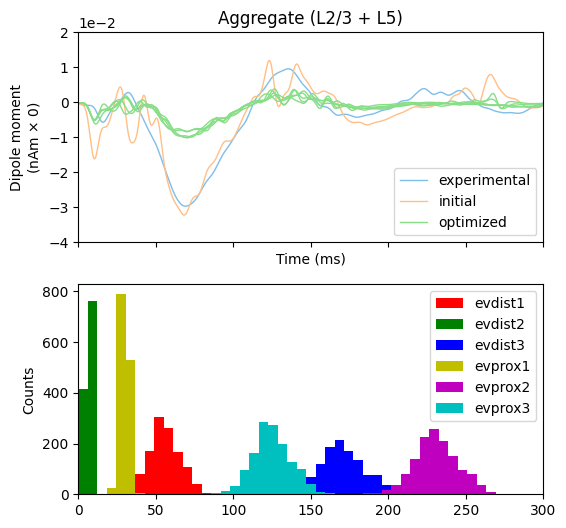

/opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/optimization/general_optimization.py:182: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(show)


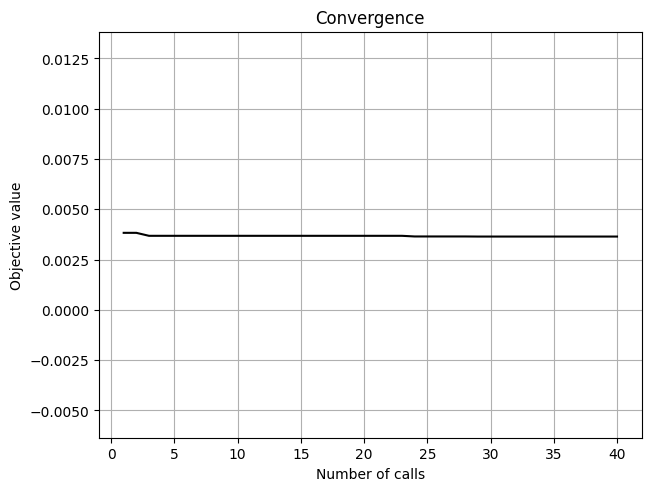

In [271]:
tstop = 300
scale_factor = 1
smooth_window_len= 10

with MPIBackend(n_procs=3, mpi_cmd='mpiexec'):
    opt_dpl = simulate_dipole(optim.net_, tstop=tstop, n_trials=5)
smoothed_opt_dpl = scale_and_smooth(opt_dpl,scaling_factor=0.3)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))

# plot original
partic_data[0].plot(ax=axes[0], layer='agg', show=False, color='tab:blue')
init_dpl_smoothed[0].plot(ax=axes[0], layer='agg', show=False, color='tab:orange')
for dpl in smoothed_opt_dpl:
    dpl.plot(ax=axes[0], layer='agg', show=False, color='tab:green')
axes[0].set_ylim(-4e-2, 2e-2)
axes[0].legend(['experimental', 'initial', 'optimized'])
optim.net_.cell_response.plot_spikes_hist(ax=axes[1])

fig1 = optim.plot_convergence()

In [9]:
# load participant data 
df = pd.read_csv('HNN_data_TEP_dipole_0_300.txt', sep = ' ')
data = [line.split('\t') for line in df.iloc[:,0].tolist()]

partic_data_l = []
partic_data_l.append([float(x[0]) for x in data])
partic_data_l.append([float(x[1]) for x in data])

In [22]:
with open(f'sim_data/net_opt_calcium_TEP.pkl', 'wb') as file:
    pickle.dump(opt_net.__dict__['_params'], file)


In [23]:

with open(f'sim_data/net_opt_calcium_TEP.pkl', 'rb') as f:
    opt_param = pickle.load(f)

In [24]:
opt_param

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

In [11]:
from hnn_core import JoblibBackend

with JoblibBackend(n_jobs=1):
    optim_dpl = simulate_dipole(opt_net, tstop=300, n_trials=1,dt=0.025,record_vsec='all',record_isec='all',record_ca='all')

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...


In [10]:
window_len, scaling_factor = 10, 0.3
smoothed_dpl = deepcopy(optim_dpl)
smoothed_dpl = [dpl.smooth(window_len).scale(scaling_factor) for dpl in smoothed_dpl]

NameError: name 'partic_data_l' is not defined

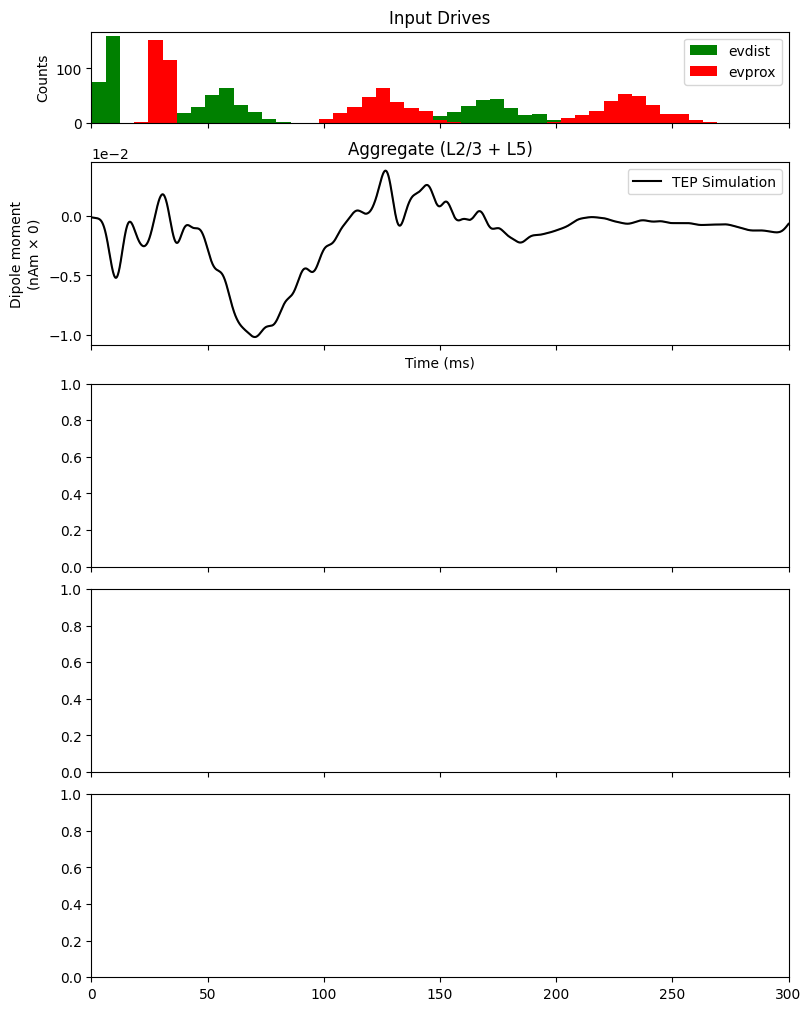

In [11]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(8, 10), constrained_layout=True, height_ratios=[1,2,2,2,2])

# plot 1: drives
opt_net.cell_response.plot_spikes_hist(ax=axes[0], spike_types=['evprox', 'evdist'], trial_idx=0, show=False)
axes[0].title.set_text('Input Drives')

# plot 2: dipole, agg and data 
avg_opt_dpls = deepcopy(smoothed_dpl)
plot_dipole(avg_opt_dpls, ax = axes[1], layer='agg', show=False, average=True, label='TEP Simulation')
# plot_dipole(partic_data[0], ax = axes[1], layer='agg', show=False, average=False, color='C0')
axes[1].plot(np.array(partic_data_l[0][:300]), np.array(partic_data_l[1][:300]), label='Data')
axes[1].legend()

ymin, ymax = axes[1].get_ylim()

# plot 3: dipole, layer 2/3
plot_dipole(avg_opt_dpls, ax = axes[2], layer='L2', show=False)
axes[2].set_ylim(ymin, ymax)

# plot 4: dipole, layer 5
plot_dipole(avg_opt_dpls, ax = axes[3], layer='L5', show=False)
axes[3].set_ylim(ymin, ymax)
axes[3].set_xlim(0,300)

# plot 5: cell spiking
opt_net.cell_response.plot_spikes_raster(ax=axes[4], show=False)
axes[4].title.set_text('Cell Spiking')

for ax in axes[:-1]:  # Iterate over all subplots except the last one
    ax.set_xlabel('') 

# fig.suptitle('Hand Tuning')

In [12]:
gids = opt_net.gid_ranges
gids['L5_pyramidal']

# find the gids of the neurons that spiked
# l5_gids = gids[np.where(((gids > 169).astype(float) + (gids <=270).astype(float)) == 2)[0]]
l5_gids = gids['L5_pyramidal']
l5_unique_gids = np.array([])
for l5 in l5_gids:
    if ~np.isin(l5,l5_unique_gids):
        l5_unique_gids = np.append(l5_unique_gids, l5)

# get calcium for each cell 
ca_l5_tuft = np.zeros((l5_unique_gids.shape[0], len(opt_net.cell_response.times)))
ca_l5_apcl2 = np.zeros((l5_unique_gids.shape[0], len(opt_net.cell_response.times)))
vltg_l5_soma = np.zeros((l5_unique_gids.shape[0], len(opt_net.cell_response.times)))
ca_l5_soma = np.zeros((l5_unique_gids.shape[0], len(opt_net.cell_response.times)))

for i, g in enumerate(l5_unique_gids.astype(int)):
    ca_l5_tuft[i] = opt_net.cell_response.ca[0][g]['apical_tuft']
    ca_l5_apcl2[i] = opt_net.cell_response.ca[0][g]['apical_2']
    ca_l5_soma[i] = opt_net.cell_response.ca[0][g]['apical_2']
    vltg_l5_soma[i] = opt_net.cell_response.vsec[0][g]['soma']

In [13]:
ca_l5_tuft_sort = deepcopy(ca_l5_tuft)

In [14]:
#sorting the cells by their peak concentration time
max_activation_times = [np.argmax(ca_l5_tuft[idx]) for idx in range(len(ca_l5_tuft))]
sort_idx = np.argsort(max_activation_times)
# sort_idx = np.asarray(sort_idx, dtype=int)
ca_l5_tuft_sort = ca_l5_tuft_sort[sort_idx][::-1, :]


print(ca_l5_tuft_sort.shape)
print(max_activation_times)

(100, 12001)
[3788, 3464, 3958, 3232, 3504, 7691, 2899, 2585, 2891, 4753, 3752, 2919, 3664, 3582, 3420, 3655, 3661, 4452, 3369, 3585, 3390, 4221, 3457, 3846, 3972, 4480, 3616, 3023, 3401, 3573, 2865, 4224, 4286, 3854, 4187, 4446, 4127, 4386, 3173, 2625, 4162, 3455, 3758, 3403, 3366, 3964, 3728, 3733, 3503, 3953, 7676, 4639, 3083, 4105, 3092, 3588, 4740, 4561, 3892, 3419, 3363, 3835, 4456, 3176, 4163, 3479, 3575, 3526, 3242, 2974, 2448, 7327, 3404, 3546, 4295, 3807, 3676, 7663, 3129, 2840, 3291, 2713, 8113, 2840, 3760, 4333, 3464, 2236, 3359, 3566, 3827, 3881, 3285, 3494, 3290, 2632, 3578, 3731, 3778, 9203]


Text(0, 0.5, 'Dipole moment (nAm)')

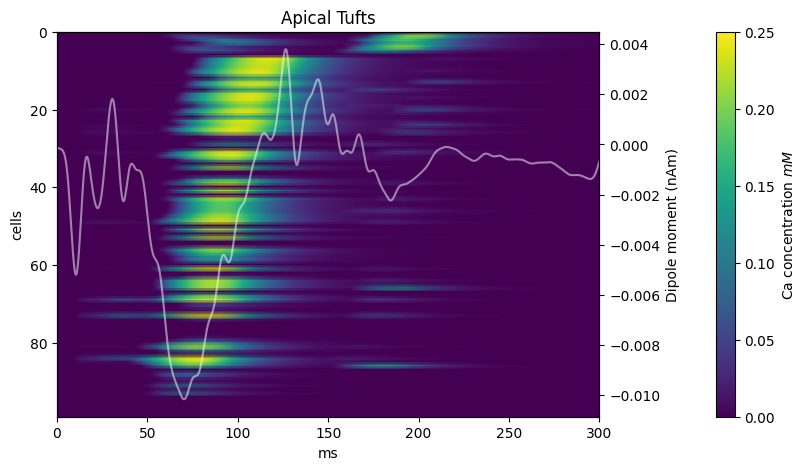

In [15]:
timevec = np.arange(0,12001,1)

# calcium concentration
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.pcolormesh(timevec,np.arange(len(l5_unique_gids)),ca_l5_tuft_sort, shading='gouraud',vmin=0, vmax=0.25)
ax.invert_yaxis()
ax.set_title('Apical Tufts')
ax.set_xlabel('ms')
ax.set_ylabel('cells')

# add colorbar
cb = plt.colorbar(im, ax= ax, pad=0.15)
cb.set_label('Ca concentration $mM$')

# convert x ticks
ax.set_xticks(np.linspace(timevec[0], timevec[-1], 7))
ax.set_xticklabels(np.linspace(0, 300, 7).astype(int))

# plot the dipole
ax2 = ax.twinx()
ax2.plot(timevec,smoothed_dpl[0].data['agg'], color=(1,1,1), alpha=0.5)
ax2.set_ylabel('Dipole moment (nAm)')

In [16]:
np.arange(0,11,1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

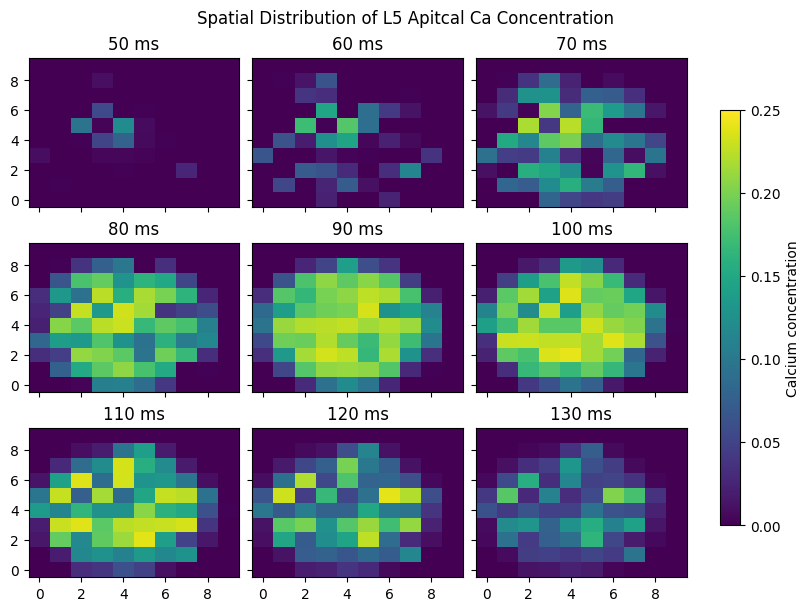

In [24]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8, 6), constrained_layout=True)

for i, ax in zip(np.arange(2000, 5600, 400), axes.flat):
# for i, ax in zip(np.arange(6000, 9600, 400), axes.flat):
    ca_concentration = ca_l5_tuft[:,i:i+1]
    grid_ca = ca_concentration.reshape((10, 10))
    c = ax.pcolormesh(np.arange(0,10,1), np.arange(0,10,1),grid_ca,shading='auto',vmin=0, vmax=0.25)
    # ax.set_xticks(np.arange(0, 10, 1))  # X-axis ticks from 1 to 10
    # ax.set_yticks(np.arange(0, 10, 1))
    # c = ax.pcolor(grid_ca, cmap='viridis')
    ax.set_title(f'{round(i/12000*300)} ms')
fig.colorbar(c, ax=axes, location='right', shrink=0.8, label='Calcium concentration')
fig.suptitle('Spatial Distribution of L5 Apitcal Ca Concentration')
plt.show()


In [287]:
with open(f'sim_data/net_opt_calcium_TEP.pkl', 'wb') as file:
    pickle.dump(optim.net_, file)